In [2]:
import numpy as np
import statsmodels.api as sm
import os
import sys
sys.path.append('/Users/datnguyen/Work/others/')

from utils.db_utils import df_from_snowflake
import matplotlib.pyplot as pp

In [100]:
query = """
with cases as (
    SELECT date_trunc('week', created_datetime) as created_date, 
            count(1)::number as cases
    FROM STAGE.derived_salesforce.salesforce_case
    WHERE 1=1
        AND owner_is_autoclose_queue = 0
        AND business_domain_channel = 'Customer Service'
        AND language_channel IN ('DE','EN', 'NL', 'IT', 'ES', 'FR', 'PL')
        and created_date >= '2023-01-02'
    group by 1
),

onsite_bookings as (
    select 
        date_trunc('week', conversion_date) as conversion_date,
        count( distinct on_site_order_id) as onsite_bookings,
        count(distinct iff(is_hometogo_payment=1,on_site_order_id, null)) as onsite_bookings_with_payment
    from STAGE.reporting.fct_conversions
    where 1=1
        -- and is_hometogo_payment = 1
        and conversion_date >= '2023-01-02'
    group by 1

)

--offers as (
--    select
--        dt,
--        count(distinct iff(offers_payment=1,offer_id, null)) as offers_htg_payment
--    from stage.derived_partner.kpi_inventory_daily
--    where 1=1
--        and dt>= '2024-01-01'
--    group by 1
--)

select
    coalesce(created_date, conversion_date ) as dt,
    onsite_bookings_with_payment,
    onsite_bookings,
    cases
    
from onsite_bookings ob
--left join offers o on ob.conversion_date = o.dt
left join cases c on ob.conversion_date = c.created_date
order by 1
"""

In [101]:
data = df_from_snowflake(query=query)

In [115]:
data['ONSITE_BOOKINGS_WITHOUT_PAYM'] = data['ONSITE_BOOKINGS'] - data['ONSITE_BOOKINGS_WITH_PAYMENT']

In [1]:
data

NameError: name 'data' is not defined

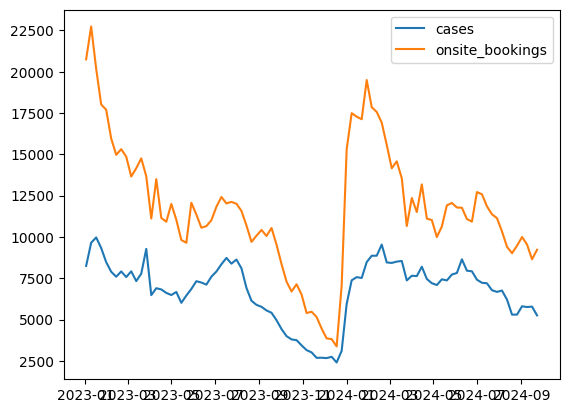

In [104]:
pp.plot(data['DT'],
    data['CASES'],
        label='cases'
        )
# pp.plot(
#     data['DT'],
#     data['ONSITE_BOOKINGS_WITH_PAYMENT'],
#     label='onsite_bookings_with_payment'
#         )
pp.plot(
    data['DT'],
    data['ONSITE_BOOKINGS'],
    label='onsite_bookings'
        )
pp.legend()


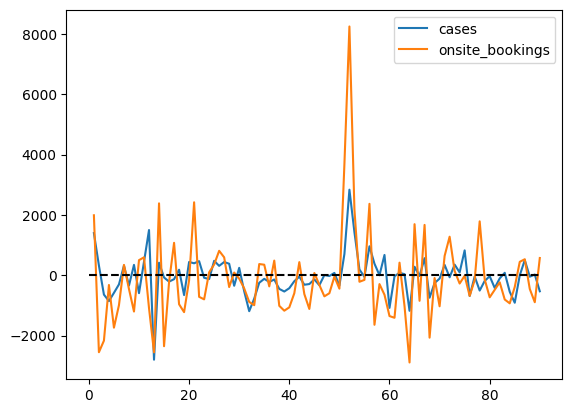

In [114]:
input = data.diff()
pp.plot(
    input['CASES'],
        label='cases'
        )
pp.plot(

    input['ONSITE_BOOKINGS'],
    label='onsite_bookings'
        )

pp.hlines(y=0, xmin=0, xmax=90,linestyles='--', colors= 'black')
pp.legend()

In [106]:
input = data.diff()
input = input.iloc[1:,]
input.exog = sm.add_constant(input[['ONSITE_BOOKINGS_WITH_PAYMENT','ONSITE_BOOKINGS']])
input.endog = input['CASES'].astype(float)

reg = sm.GLM(input.endog, input.exog, family=sm.families.Gaussian())
result = reg.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  CASES   No. Observations:                   90
Model:                            GLM   Df Residuals:                       87
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                      2.6233e+05
Method:                          IRLS   Log-Likelihood:                -687.66
Date:                Tue, 01 Oct 2024   Deviance:                   2.2823e+07
Time:                        15:01:09   Pearson chi2:                 2.28e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5086
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_40726/3118960018.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  input.exog = sm.add_constant(input[['ONSITE_BOOKINGS_WITH_PAYMENT','ONSITE_BOOKINGS']])
/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_40726/3118960018.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  input.endog = input['CASES'].astype(float)


In [116]:
input = data.diff()
input = input.iloc[1:,]
input.exog = sm.add_constant(input[['ONSITE_BOOKINGS_WITH_PAYMENT','ONSITE_BOOKINGS_WITHOUT_PAYM']])
input.endog = input['CASES'].astype(float)

reg = sm.GLM(input.endog, input.exog, family=sm.families.Gaussian())
result = reg.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  CASES   No. Observations:                   90
Model:                            GLM   Df Residuals:                       87
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                      2.6233e+05
Method:                          IRLS   Log-Likelihood:                -687.66
Date:                Wed, 02 Oct 2024   Deviance:                   2.2823e+07
Time:                        15:06:33   Pearson chi2:                 2.28e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5086
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_40726/1375037338.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  input.exog = sm.add_constant(input[['ONSITE_BOOKINGS_WITH_PAYMENT','ONSITE_BOOKINGS_WITHOUT_PAYM']])
/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_40726/1375037338.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  input.endog = input['CASES'].astype(float)


In [107]:
input = data.diff()
input = input.iloc[1:,]
input.exog = sm.add_constant(input['ONSITE_BOOKINGS'])
input.endog = input['CASES'].astype(float)

reg = sm.GLM(input.endog, input.exog, family=sm.families.Gaussian())
result = reg.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  CASES   No. Observations:                   90
Model:                            GLM   Df Residuals:                       88
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      2.6259e+05
Method:                          IRLS   Log-Likelihood:                -688.22
Date:                Tue, 01 Oct 2024   Deviance:                   2.3108e+07
Time:                        15:01:20   Pearson chi2:                 2.31e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5021
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.3325     54.223     

/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_40726/790914409.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  input.exog = sm.add_constant(input['ONSITE_BOOKINGS'])
/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_40726/790914409.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  input.endog = input['CASES'].astype(float)


In [17]:
query_paym_cases = """
with paym_cases as (
    select date_trunc(week, created_datetime) as week,
    count(case_id) as paym_cases
from STAGE.REPORTING_CUSTOMER_SUCCESS.FCT_CASES
where sub_topic ilike '%payment%'
    and created_datetime >= '2023-01-02'
group by 1
order by 1
),

onsite_bookings_w_paym as (
    select 
        date_trunc('week', conversion_date) as week,
        count(distinct iff(is_hometogo_payment=1,on_site_order_id, null)) as onsite_bookings_with_payment
    from STAGE.reporting.fct_conversions
    where 1=1
        and conversion_date >= '2023-01-02'
    group by 1
),

offers as (
    select
        dt,
        count(distinct iff(offers_payment=1,offer_id, null)) as offers_htg_payment
    from stage.derived_partner.kpi_inventory_daily
    where 1=1
        and dt>= '2024-01-01'
    group by 1
)

select 
    c.week,
    c.paym_cases,
    b.onsite_bookings_with_payment,
    o.offers_htg_payment,
    c.paym_cases/b.onsite_bookings_with_payment as booking_to_case_ratio,
    c.paym_cases/o.offers_htg_payment as offer_to_case_ratio
from paym_cases c
inner join onsite_bookings_w_paym b using (week)
left join offers o on c.week = o.dt
order by 1
"""

In [18]:
paym_cases_df = df_from_snowflake(query=query_paym_cases)
paym_cases_df

,WEEK,PAYM_CASES,ONSITE_BOOKINGS_WITH_PAYMENT,OFFERS_HTG_PAYMENT,BOOKING_TO_CASE_RATIO,OFFER_TO_CASE_RATIO
0,2023-01-02,704,320,NaN,2.200000,None
1,2023-01-09,788,441,NaN,1.786848,None
2,2023-01-16,872,415,NaN,2.101205,None
3,2023-01-23,815,472,NaN,1.726695,None
4,2023-01-30,718,491,NaN,1.462322,None
...,...,...,...,...,...,...
88,2024-09-09,550,1487,252965.0,0.369872,0.002174
89,2024-09-16,495,1363,256265.0,0.363169,0.001932
90,2024-09-23,386,1464,247861.0,0.263661,0.001557
91,2024-09-30,364,1465,246868.0,0.248464,0.001474


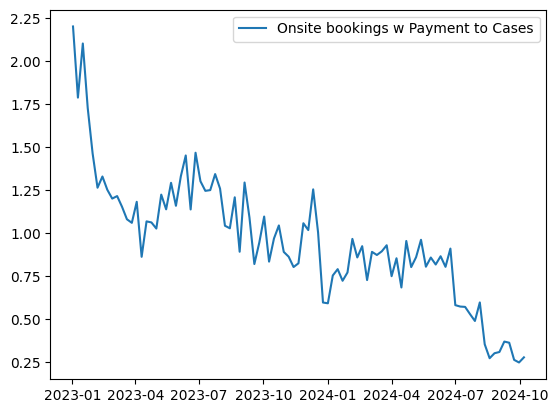

In [28]:
pp.plot(
        paym_cases_df['WEEK'],
        paym_cases_df['BOOKING_TO_CASE_RATIO'],
        label='Onsite bookings w Payment to Cases'

        )
pp.legend()

In [16]:
# Ratio since htg-payment was introduced
paym_cases_df['BOOKING_TO_CASE_RATIO'][paym_cases_df['WEEK'] >= '2024-01-01'].mean()

0.6759562195121951

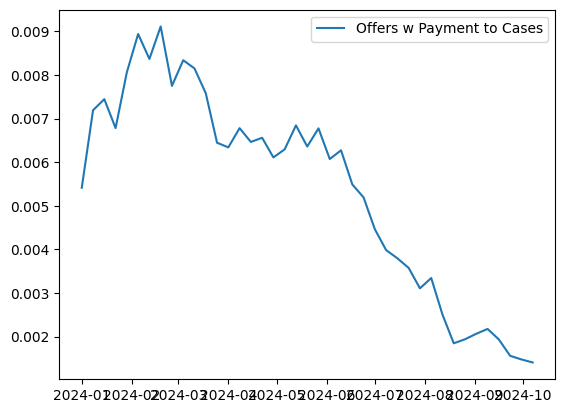

In [29]:
pp.plot(
        paym_cases_df['WEEK'],
        paym_cases_df['OFFER_TO_CASE_RATIO'],
        label='Offers w Payment to Cases'

        )
pp.legend()

In [22]:
# Ratio since htg-payment was introduced
paym_cases_df['OFFER_TO_CASE_RATIO'][paym_cases_df['WEEK'] >= '2024-01-01'].mean()

0.005372487804878048